In [2]:
#############################################################################
# File: DS312_Project3_RachelNewman
# Author: Rachel Newman
# Purpose: Implement 5-fold cross-validation on Diabetes dataset with 
#          Linear Regression, Ridge Regression, and Lasso Regression. 
# Resources: Collaborated with Jerome Busquin for Question 2 and Question 3
#            for Project 2. The work for Question 1 and Question 4 are my 
#            own work. 
############################################################################

You will be working with the Diabetese dataset, which contains information about various physiological factors and their influence on the progression of diabetes. The dataset includes 10 features (or predictors) derived from diagnostic measurements and medical records. The target variable represents a quantitative measure of disease progression one year after base line. 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Question 1: Exploratory Data Analysis (EDA)

### Load the diabetes dataset and perform initial data exploration.

In [8]:
from sklearn.datasets import load_diabetes
# Load the diabetes dataset
diabetes_data = load_diabetes()
print(diabetes_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [9]:
## creating a dataframe for diabetes data
diabetes = pd.DataFrame(diabetes_data.data, columns = diabetes_data.feature_names)

In [10]:
## adding target variable to data frame
diabetes['disease progression'] = diabetes_data.target
## showing the first 5 entries in the data frame
diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Check for missing values and handle them if necessary

In [12]:
## checking to see if there are any missing variables 
print(diabetes.isnull().sum())

age                    0
sex                    0
bmi                    0
bp                     0
s1                     0
s2                     0
s3                     0
s4                     0
s5                     0
s6                     0
disease progression    0
dtype: int64


There are no missing values for this data set so I can proceed like normal. If there were missing values, I could drop them from the data set if there were a small number, or if there were a large number of missing values, I could use mean/median values to replace them. 

In [14]:
## looking at the statistical summary of diabetes data
diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Visualize the data to understand the distribution of key features and their relationship with the target variable "disease progression". Recommended visualizations inclue:
- A heat map of the correlation matrix to explore relationships between features and detect multicollinearity.
- Scatter plots of some important features against "disease progression" to identify potential correlations.

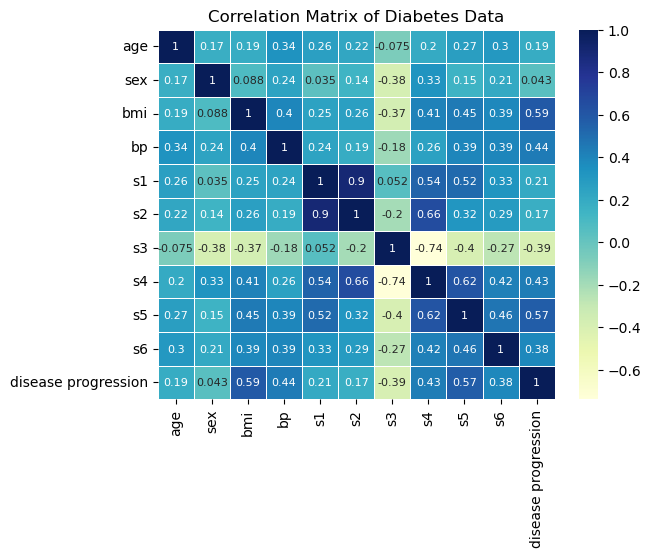

In [16]:
## computing a correlation matrix for the data
correlation_matrix = diabetes.corr()

## plotting a heat map to explore relationships between features 
fig = plt.figure()
sns.heatmap(correlation_matrix, cmap = 'YlGnBu', linewidths = 0.5, fmt = '.2g', annot = True, annot_kws = {"size": 8})
plt.title('Correlation Matrix of Diabetes Data')
plt.show()

In [17]:
## creating a new dataframe with only important features
diabetes.keys()
diabetes_new = diabetes.drop(['sex', 'age', 's2', 's1', 'disease progression'], axis = 1)
diabetes_new.head()

,bmi,bp,s3,s4,s5,s6
0,0.061696,0.021872,-0.043401,-0.002592,0.019907,-0.017646
1,-0.051474,-0.026328,0.074412,-0.039493,-0.068332,-0.092204
2,0.044451,-0.005670,-0.032356,-0.002592,0.002861,-0.025930
3,-0.011595,-0.036656,-0.036038,0.034309,0.022688,-0.009362
4,-0.036385,0.021872,0.008142,-0.002592,-0.031988,-0.046641


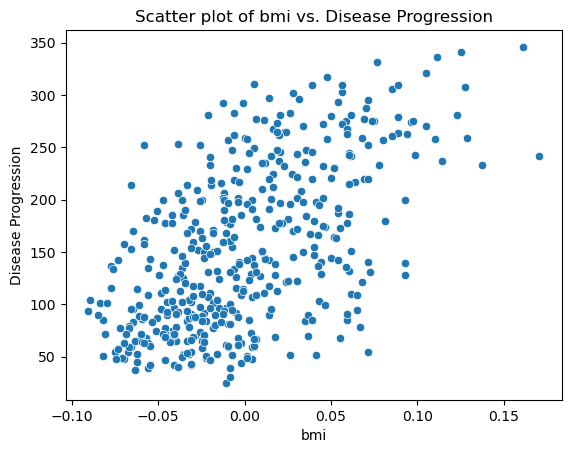

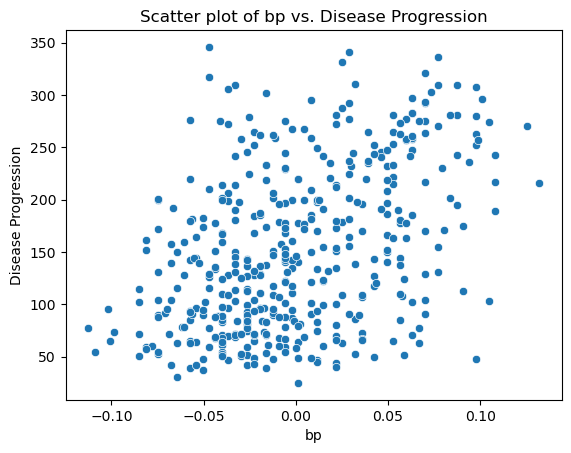

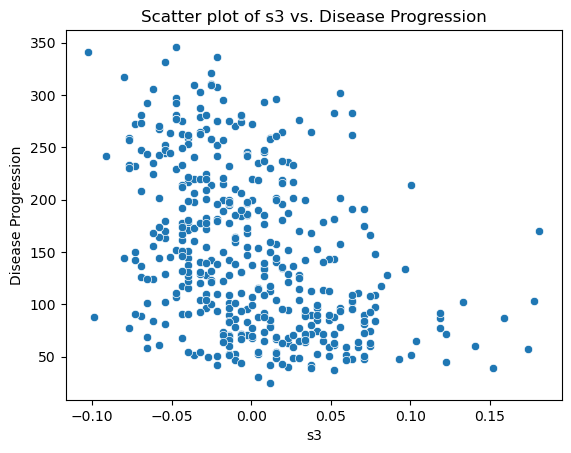

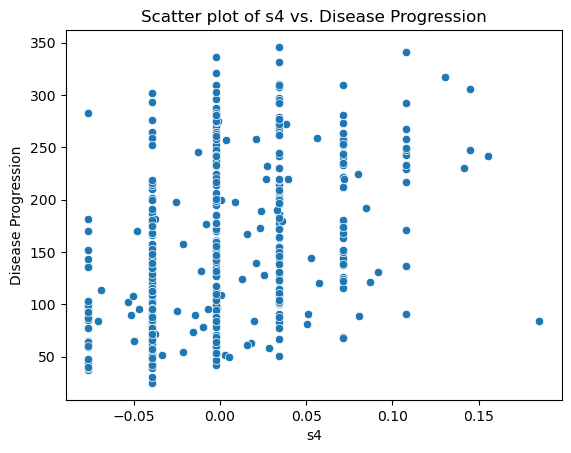

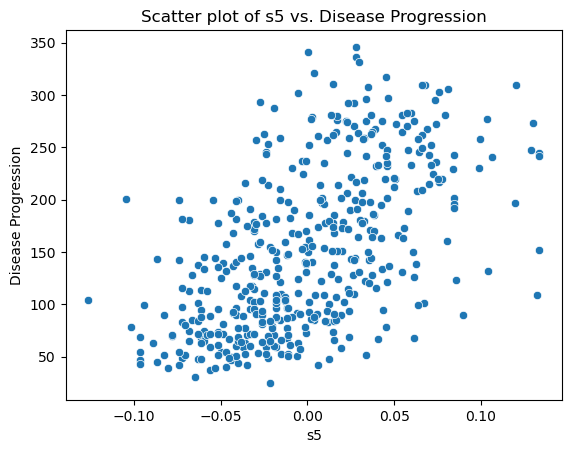

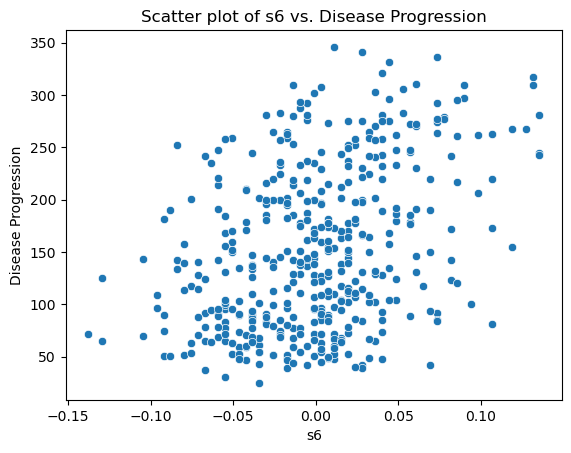

In [18]:
## plotting scatter plots for important features
for feature in diabetes_new: 
    plt.figure()
    sns.scatterplot(x = diabetes_new[feature], y = diabetes['disease progression'])
    plt.title(f'Scatter plot of {feature} vs. Disease Progression')
    plt.xlabel(feature)
    plt.ylabel('Disease Progression')
    plt.show()

# Question 2: Linear Regression with 5-fold Cross-Validation

### Implement 5-fold Cross Validation using Linear Regression on the dataset

In [22]:
diabetes.keys()

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'disease progression'],
      dtype='object')

In [28]:
## extracting features and target from dataset. I'm using the important features only, and ignoring the rest for now
x = diabetes_data.data
y = diabetes['disease progression']

In [29]:
## initializing linear regression model
linear_model = LinearRegression()

## implementing 5-fold cross-validation
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [30]:
## creating arrays to store R² and MAE for each fold
R2_scores = []
MAE_scores = []
coefficients = []

## perform cross-validation
for train_index, test_index in k_fold.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ## fitting the model
    linear_model.fit(x_train, y_train)

    ## making predictions on the test set
    y_pred = linear_model.predict(x_test)

    ## calculate R²  and MAE
    R2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    ## store the results in the arrays
    R2_scores.append(R2)
    MAE_scores.append(mae)

    ## store coefficients of the model in an array
    coefficients.append(linear_model.coef_)

In [31]:
print(f'R² values for 5-fold cross-validation are: {R2_scores}')
print(f'MAE values for 5-fold cross-validation are: {MAE_scores}')

R² values for 5-fold cross-validation are: [0.33223321731061806, 0.4597042542458907, 0.5370636865383392, 0.521653908550179, 0.595119800581946]
MAE values for 5-fold cross-validation are: [46.1735850037048, 43.58195742468968, 45.72638470098914, 42.35028879490521, 43.62921474523517]


### Display the coefficients of the Linear Regression model

In [35]:
## displaying coefficients of first fold
print(f'The coefficients of the first fold are: {coefficients[0]}')

The coefficients of the first fold are: [ -35.55025079 -243.16508959  562.76234744  305.46348218 -662.70290089
  324.20738537   24.74879489  170.3249615   731.63743545   43.0309307 ]


In [36]:
## displaying coefficients of second fold
print(f'The coefficents of the second fold are: {coefficients[1]}')

The coefficents of the second fold are: [ -34.78787819 -229.55596473  501.94853261  367.9141114  -876.33249621
  566.32431695  113.15619635  117.86575744  819.4209983    73.43947205]


In [37]:
## displaying coefficients of third fold 
print(f'The coefficents of the third fold are: {coefficients[2]}')

The coefficents of the third fold are: [  26.06111199 -266.59789647  541.66878643  299.14660527 -661.89401041
  444.98781914   16.19754441   97.54151537  702.55150125   39.07373296]


In [38]:
## displaying coefficients of fourth fold
print(f'The coefficients of the fourth fold are: {coefficients[3]}')

The coefficients of the fourth fold are: [  17.41778395 -228.49558749  499.00721333  303.74915406 -640.29568441
  320.26196732   93.58650579  264.46179075  693.4408735    79.17438913]


In [39]:
## displaying coefficients of the fifth fold
print(f'The coefficients of the fifth fold are: {coefficients[4]}')

The coefficients of the fifth fold are: [  -25.65955766  -233.72523112   500.7125654    342.1347386
 -1151.55852101   755.235571     262.88565389   228.90918846
   804.43607216   115.15256262]


### Calculate and report the average R² value and Mean Absolute Error (MAE) across the test sets for all folds

In [46]:
avg_R2 = np.mean(R2_scores)
avg_MAE = np.mean(MAE_scores)
print(f'The average R² value across 5 folds is: {avg_R2}')
print(f'The average MAE value across 5 folds is: {avg_MAE}')

The average R² value across 5 folds is: 0.4891549734453946
The average MAE value across 5 folds is: 44.2922861339048


# Question 3: Ridge Regression with 5-fold Cross-Validation

### Implement Ridge Regression with 5-fold cross-validation on the Diabetes dataset, tuning the regularization with the regularization parameter to α = 0.013257

In [56]:
## setting the regularization parameter α
alpha = 0.01357

## initializing Ridge regression model
Ridge_model = Ridge(alpha = alpha)

## implementing 5-fold cross-validation
k_fold_Ridge = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [58]:
## creating arrays to store R² and MAE values for Ridge Regression
R2_scores_Ridge = []
MAE_scores_Ridge = []
coefficients_Ridge = []

## perform cross-validation
for train_index, test_index in k_fold_Ridge.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ## fitting the model
    Ridge_model.fit(x_train, y_train)

    ## making predictions on the test set
    y_pred = Ridge_model.predict(x_test)

    ## calculate R²  and MAE
    R2_Ridge = r2_score(y_test, y_pred)
    mae_Ridge = mean_absolute_error(y_test, y_pred)

    ## store the results in the arrays
    R2_scores_Ridge.append(R2_Ridge)
    MAE_scores_Ridge.append(mae_Ridge)

    ## store coefficients of model
    coefficients_Ridge.append(Ridge_model.coef_)

### Display the coefficients of the Ridge Regression model

In [61]:
## displaying the coefficients of first fold
print(f'The coefficients for Ridge Regression on first fold are: {coefficients_Ridge[0]}')

The coefficients for Ridge Regression on first fold are: [ -30.59950866 -236.14864082  561.9052237   298.19204711 -264.35933921
   13.09568041 -152.42854994  118.67215535  571.99936274   49.06643453]


In [63]:
## displaying the coefficients of second fold
print(f'The coefficients for Ridge Regression on second fold are: {coefficients_Ridge[1]}')

The coefficients for Ridge Regression on second fold are: [ -30.51038395 -221.27014159  503.31821187  361.58722846 -287.76444751
   88.72649525 -127.99591873   74.70491261  593.48827864   76.60146891]


In [65]:
## displaying the coefficients of third fold
print(f'The coefficients for Ridge Regression on third fold are: {coefficients_Ridge[2]}')

The coefficients for Ridge Regression on third fold are: [  26.40423091 -260.11154473  539.05381544  295.34059085 -244.31192686
  112.08583897 -160.80495332   60.00060491  533.47135527   43.11485315]


In [67]:
## displaying the coefficients of fourth fold
print(f'The coefficients for Ridge Regression on fourth fold are: {coefficients_Ridge[3]}')

The coefficients for Ridge Regression on fourth fold are: [  20.74687565 -219.51742804  495.71185706  298.49444122 -209.7364151
  -12.56159779 -104.37330543  202.76867939  523.45477908   89.13448204]


In [69]:
## displaying the coefficients of fifth fold
print(f'The coefficients for Ridge Regression on fifth fold are: {coefficients_Ridge[4]}')

The coefficients for Ridge Regression on fifth fold are: [ -18.24646745 -224.82353555  499.3157386   337.45655441 -412.22022328
  165.90107812  -53.45534406  151.4042057   528.78236803  114.89774579]


### Calculate and report R² and MAE across the test set for all folds

In [72]:
avg_R2_Ridge = np.mean(R2_scores_Ridge)
avg_MAE_Ridge = np.mean(MAE_scores_Ridge)
print(f'The average R² value for Ridge Regression across 5 folds is: {avg_R2_Ridge}')
print(f'The average MAE value for Ridge Regression across 5 folds is: {avg_MAE_Ridge}')

The average R² value for Ridge Regression across 5 folds is: 0.4893134804942493
The average MAE value for Ridge Regression across 5 folds is: 44.27197709566492


# Question 4: Lasso Regression with 5-fold cross-validation

### Implement Lasso Regression with 5-fold cross-validation on the Diabetes dataset, tuning the regularization with the regularization parameter to α = 0.013257

In [76]:
## setting the regularization parameter α
alpha = 0.01357

## initializing Lasso Regression model
Lasso_model = Lasso(alpha = alpha)

## 5-fold cross validation
k_fold_Lasso = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [78]:
## creating arrays to store R² and MAE values for Lasso Regression
R2_scores_Lasso = []
MAE_scores_Lasso = []
coefficients_Lasso = []

## perform cross-validation
for train_index, test_index in k_fold_Lasso.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ## fitting the model
    Lasso_model.fit(x_train, y_train)

    ## making predictions on the test set
    y_pred = Lasso_model.predict(x_test)

    ## calculate R²  and MAE
    R2_Lasso = r2_score(y_test, y_pred)
    mae_Lasso = mean_absolute_error(y_test, y_pred)

    ## store the results in the arrays
    R2_scores_Lasso.append(R2_Lasso)
    MAE_scores_Lasso.append(mae_Lasso)

    ## store coefficients of model
    coefficients_Lasso.append(Lasso_model.coef_)

### Display the coefficients of the Lasso Regression model

In [81]:
## displaying coeffients of first fold for Lasso Regression
print(f'The coefficients for Lasso Regression on first fold are: {coefficients_Lasso[0]}')

The coefficients for Lasso Regression on first fold are: [ -23.55580531 -230.24353016  568.87635529  291.81542656 -240.62612672
    0.         -165.3168296    97.38735557  576.31715531   39.90867975]


In [83]:
## displaying coeffients of second fold for Lasso Regression
print(f'The coefficients for Lasso Regression on second fold are: {coefficients_Lasso[1]}')

The coefficients for Lasso Regression on second fold are: [ -23.83879796 -214.02039708  510.860087    357.62656769 -176.29380331
    0.         -174.81031806   50.66702804  565.19379926   67.55592868]


In [85]:
## displaying coeffients of third fold for Lasso Regression
print(f'The coefficients for Lasso Regression on third fold are: {coefficients_Lasso[2]}')

The coefficients for Lasso Regression on third fold are: [  19.66833526 -251.88984474  548.52922402  292.13354733  -92.15985671
    0.         -230.63649406   19.56851519  490.84003641   35.51827812]


In [87]:
## displaying coeffients of fourth fold for Lasso Regression
print(f'The coefficients for Lasso Regression on fourth fold are: {coefficients_Lasso[3]}')

The coefficients for Lasso Regression on fourth fold are: [  12.97300587 -212.35825691  501.81345665  296.88577481 -221.41539143
   -0.          -91.8116503   196.59465534  540.08358819   82.12745214]


In [89]:
## displaying coeffients of fifth fold for Lasso Regression
print(f'The coefficients for Lasso Regression on fifth fold are: {coefficients_Lasso[4]}')

The coefficients for Lasso Regression on fifth fold are: [ -12.00764438 -219.09948364  505.42480311  333.14945545 -483.00315753
  217.86356752  -13.63549759  159.62502397  562.08527948  106.60426264]


### Calculate and report R² and MAE across the test set for all folds

In [92]:
avg_R2_Lasso = np.mean(R2_scores_Lasso)
avg_MAE_Lasso = np.mean(MAE_scores_Lasso)
print(f'The average R² value for Lasso Regression across 5 folds is: {avg_R2_Lasso}')
print(f'The average MAE value for Lasso Regression across 5 folds is: {avg_MAE_Lasso}')

The average R² value for Lasso Regression across 5 folds is: 0.4887788982760137
The average MAE value for Lasso Regression across 5 folds is: 44.30123177678869


# Question 5: Performance Comparison of Models

### Compare the performance of Linear Regression, Ridge Regression, and Lasso Regression using 5-fold cross-validation.

In [96]:
## comparing the performance of Linear Regression
print(f'The average R² value for Linear Regression across 5 folds is: {avg_R2}')
print(f'The average MAE value for Linear Regression across 5 folds is: {avg_MAE}\n')

## comparing the performance of Ridge Regression
print(f'The average R² value for Ridge Regression across 5 folds is: {avg_R2_Ridge}')
print(f'The average MAE value for Ridge Regression across 5 folds is: {avg_MAE_Ridge}\n')

## comparing the performance of Lasso Regression
print(f'The average R² value for Lasso Regression across 5 folds is: {avg_R2_Lasso}')
print(f'The average MAE value for Lasso Regression across 5 folds is: {avg_MAE_Lasso}')

The average R² value for Linear Regression across 5 folds is: 0.4891549734453946
The average MAE value for Linear Regression across 5 folds is: 44.2922861339048

The average R² value for Ridge Regression across 5 folds is: 0.4893134804942493
The average MAE value for Ridge Regression across 5 folds is: 44.27197709566492

The average R² value for Lasso Regression across 5 folds is: 0.4887788982760137
The average MAE value for Lasso Regression across 5 folds is: 44.30123177678869


### Plot the average R² values and MAE values for each model to visualize their performance

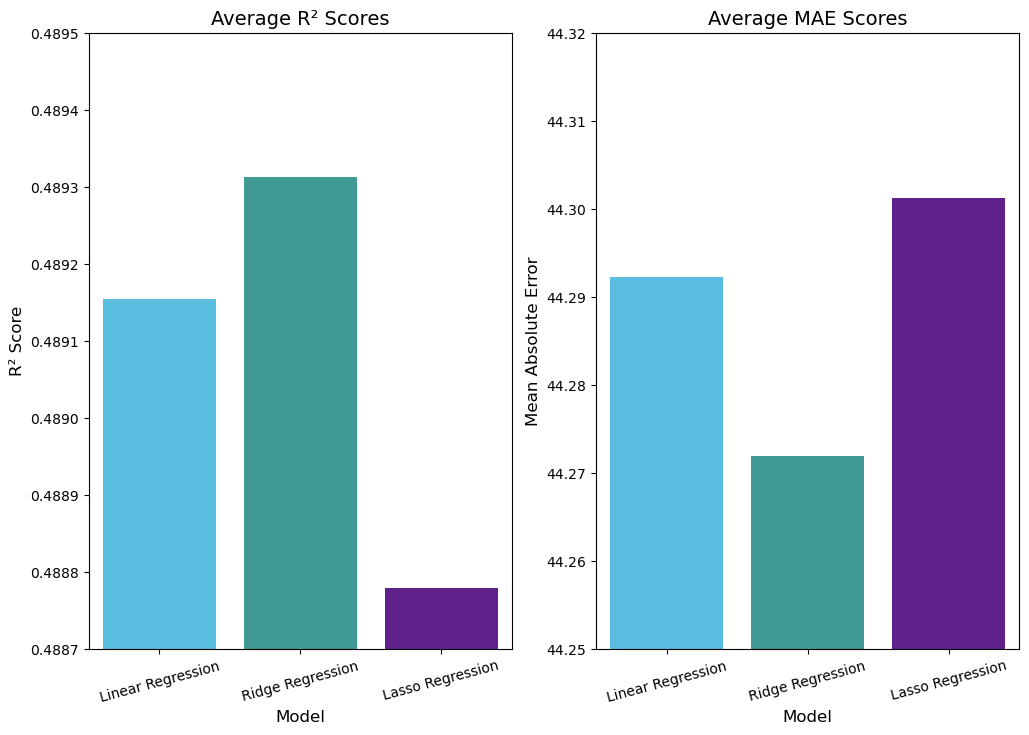

In [138]:
## plotting the R² values for each model 
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
avg_R2_values = [avg_R2, avg_R2_Ridge, avg_R2_Lasso]
avg_MAE_values = [avg_MAE, avg_MAE_Ridge, avg_MAE_Lasso]

# creating DataFrames for plotting
R2_df = pd.DataFrame({'Model': models, 'R2_Score': avg_R2_values})
MAE_df = pd.DataFrame({'Model': models, 'MAE': avg_MAE_values})

# defining colors for each model
colors = ['#42c8f5', '#32a8a0', '#64109c']
palette = dict(zip(models, colors))

# Plotting Average R² Values
plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
sns.barplot(data = R2_df, x = 'Model', y = 'R2_Score', hue = 'Model', palette = palette, dodge = False)
plt.title('Average R² Scores', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0.4887, 0.4895)
plt.legend([], [], frameon=False);  # hide the legend if not needed

# Plotting Average MAE Values
plt.subplot(1, 2, 2)
sns.barplot(data = MAE_df, x = 'Model', y = 'MAE', hue = 'Model', palette = palette, dodge = False)
plt.title('Average MAE Scores', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.ylim(44.25, 44.32)
plt.legend([], [], frameon=False)  # Hide the legend if not needed

### Analyze the model coefficients after applying regularization with Ridge and Lasso Regression. Discuss any noticeable changes in the coefficients compared to Linear Regression and how these changes affect model generalization.

#### Performance comparison of R² and MAE Values:
As seen above in the two figures, the Ridge Regression model had a higher R² and a lower MAE value when compared to Linear Regression and Lasso Regresiion. The Ridge Regression model had an R² = 0.4893 and a MAE = 44.27. The Ridge Regression model reduces the magnitude of the coefficients and improves generalization by reducing overfitting on the data. The Lasso Regression model had a R² value of 0.4887 and an MAE value of 44.30. Lasso Regression shrinks coefficients and can also set some to 0, which helps reduce the number of features and can improve the accuracy of the model (because the model is learning underlying patterns in the data by only using features that are relevant to the target variable). The Linear Regression model had an R² value of 0.48915 and an MAE value of 44.29. 

#### Effect of Regularization on Coefficients
For Linear Regression, all 10 features will have non-zero coefficients because the model is attempting to fit the best possible line through the data by minimizing the sum of squared residuals, and due to the fact that there is no regularization term in Linear Regression, the model has no restriction on the size of the coefficients. This means that every feature in the Diabetes dataset is being used to contribute to the prediction of target variable "Disease Progression", even if they have little to no relevance. For Ridge Regression, the coefficients will be smaller when compared to Linear Regression, but no coefficients will be exactly 0 because a penalty is added for large coefficients with L2 regularization, which adds the penalty to the sum of the squared coefficients. Ridge Regression shrinks the magnitude of the coefficients, especially on features that do not have much significance on predicting "Disease Progression". In Lasso Regression, L1 regularization is used, which applies a linear penalty to the absolute value of the coefficients. Lasso Regression can essentially perform automatic feature selection because the model is able to identify weak and irrelevant features. 